## 正则化 — 使用Gluon
本章介绍如何使用Gluon的正则化来应对过拟合问题。
实际上本文用的是tensorflow的正则化。

### 高维线性回归数据集
我们使用与上一节相同的高维线性回归为例来引入一个过拟合问题。

In [1]:
import numpy as np

num_train = 20
num_test = 100
# 特征维数
num_inputs = 200

### 生成数据集
这里定义模型真实参数。

In [2]:
true_w = np.ones((num_inputs, 1)) * 0.01
true_b = 0.05

我们接着生成训练和测试数据集。



In [3]:
X = np.random.normal(size=(num_train + num_test, num_inputs))
y = np.matmul(X, true_w) + true_b
y += .01 * np.random.normal(size=y.shape)
X_train, X_test = X[:num_train, :], X[num_train:, :]
y_train, y_test = y[:num_train], y[num_train:]

当我们开始训练神经网络的时候，我们需要不断读取数据块。这里我们定义一个函数它每次返回`batch_size`个随机的样本和对应的目标。我们通过python的`yield`来构造一个迭代器。

In [4]:
import random
batch_size = 1
def data_iter(X, y, num_examples, num_epochs, batch_size, shuffle=True):
    idx = list(range(num_examples*num_epochs))
    #random.shuffle(idx)
    batch_X = []
    batch_y = []
    for i in idx:
        i %= num_examples
        batch_X.append(X[i])
        batch_y.append(y[i])
        if len(batch_X) == batch_size:
            yield np.array(batch_X), np.array(batch_y)
            batch_X = []
            batch_y = []

### 定义训练和测试
跟前一样定义训练模块。你也许发现了主要区别，Trainer有一个新参数wd。我们通过优化算法的wd参数 (weight decay)实现对模型的正则化。这相当于L2L2范数正则化。实际上本文用的是tensorflow的正则化。



In [16]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def weight_variable(shape):
    """Create a weight variable with appropriate initialization."""
    #initial = tf.truncated_normal(shape, stddev=0.1)
    with tf.name_scope('weights'):
        initial = tf.random_normal_initializer(mean=0.0, stddev=1.0, seed=None, dtype=tf.float32)
#        initial =  tf.zeros_initializer(dtype=tf.float32)
    return tf.Variable(initial(shape))

def bias_variable(shape):
    """Create a bias variable with appropriate initialization."""
    with tf.name_scope('bias'):
        initial = tf.constant(0.0, shape=shape)
    return tf.Variable(initial)  

def init_params():
    w = weight_variable([num_inputs, 1])
    b = bias_variable([1])
    params = [w, b]
    return params

def net(X, w, b):
    return tf.matmul(X, w) + b

def test(net, params, X, y):
    #return square_loss(net(X, *params), y).mean().asscalar()
    return square_loss(net(X, params[0], params[1]), y) 

def train(lambd):
    num_epochs = 50
    learning_rate = 0.01
    batch_size = 10
    input_placeholder = tf.placeholder(tf.float32, [None, num_inputs])
    gt_placeholder = tf.placeholder(tf.float32, [None, 1])
    w, b = params = init_params()
    train_loss = []
    test_loss = []
    output = net(input_placeholder, w, b)
    loss = tf.reduce_mean(tf.square(output - gt_placeholder))
    for var in tf.global_variables():
        loss += lambd * tf.nn.l2_loss(var)
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    grad = tf.gradients(loss, [w, b])
    init = tf.global_variables_initializer()
    sess = tf.InteractiveSession()
    sess.run(init)
    
    for batch_X, batch_y in data_iter(X_train, y_train, num_train, num_epochs, batch_size, shuffle=False):
        output_, loss_, grad_,  _ = sess.run([output, loss, grad, train_op], feed_dict={input_placeholder: batch_X, gt_placeholder: batch_y})
        train_loss.append(sess.run(loss, feed_dict={input_placeholder: X_train, gt_placeholder: y_train}))
        test_loss.append(sess.run(loss, feed_dict={input_placeholder: X_test, gt_placeholder: y_test}))
    plt.plot(train_loss)
    plt.plot(test_loss)
    plt.legend(['train', 'test'])
    plt.show()


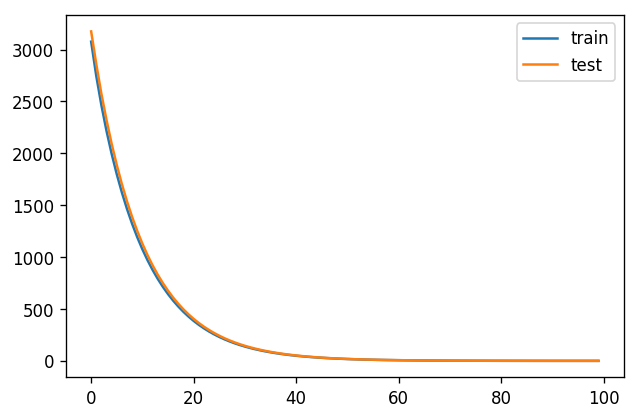

In [18]:
train(5)